In [1]:
%pip install plotly ipywidgets

  Using cached plotly-6.5.0-py3-none-any.whl.metadata (8.5 kB)
  Using cached narwhals-2.13.0-py3-none-any.whl.metadata (12 kB)
Using cached plotly-6.5.0-py3-none-any.whl (9.9 MB)
Using cached narwhals-2.13.0-py3-none-any.whl (426 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [plotly]2m1/2 [plotly]
Note: you may need to restart the kernel to use updated packages.


# AIMS Data Quality Monitoring Dashboard

This notebook provides monitoring and observability for the AIMS Data Platform.

## Purpose
- View watermark status (which files have been processed)
- Review Data Quality validation results
- Analyze DQ trends and patterns
- Generate alerts for failures

## Local Execution
Reads logs from `data/state/` directory generated by Notebook 02

In [ ]:
# Step 1: Import Libraries and Shared Utilities
import pandas as pd
import json
import os
from pathlib import Path
import matplotlib.pyplot as plt
from IPython.display import display
from datetime import datetime
import logging

# Try to import shared utilities, with fallback for standalone execution
try:
    from notebooks.config import settings
    from notebooks.lib import platform_utils, logging_utils
    
    # Setup logger for this notebook
    logger = logging_utils.setup_notebook_logger("aims_monitoring")
    
    print("✅ Libraries imported successfully")
    print(f"   Environment: {settings.environment}")
    
except ImportError as e:
    print(f"⚠️ Falling back to inline configuration: {e}")
    
    # Basic logging fallback
    logging.basicConfig(level=logging.INFO)
    logger = logging.getLogger("aims_monitoring")
    
    # Define minimal platform_utils fallback
    class platform_utils:
        IS_FABRIC = Path("/lakehouse/default/Files").exists()
        
        @staticmethod
        def file_exists(path):
            return Path(path).exists()
    
    # Define minimal settings fallback
    class settings:
        environment = "fabric_dev" if platform_utils.IS_FABRIC else "local"
        if platform_utils.IS_FABRIC:
            state_dir = Path("/lakehouse/default/Files/state")
        else:
            _notebook_dir = Path.cwd()
            _base_dir = _notebook_dir.parent if _notebook_dir.name == "notebooks" else _notebook_dir
            state_dir = _base_dir / "data" / "state"
    
    print(f"   Using fallback configuration for {'Fabric' if platform_utils.IS_FABRIC else 'Local'}")

Libraries imported successfully


In [ ]:
# Step 2: Configuration - Use Centralized Settings
# No more inline environment detection - use shared utilities

IS_FABRIC = platform_utils.IS_FABRIC
print(f"Running in {'Microsoft Fabric' if IS_FABRIC else 'Local Development'}")

# Use centralized paths from settings
STATE_DIR = settings.state_dir

# Define state files (generated by Notebook 02)
WATERMARK_FILE = STATE_DIR / "watermarks.json"
DQ_LOG_FILE = STATE_DIR / "dq_results.jsonl"

print(f"\nConfiguration:")
print(f"  State Directory: {STATE_DIR}")
print(f"  Watermark File: {WATERMARK_FILE}")
print(f"  DQ Log File: {DQ_LOG_FILE}")

# Verify files exist
if platform_utils.file_exists(WATERMARK_FILE):
    print(f"  ✅ Watermark file found")
else:
    print(f"  ⚠️  Watermark file not found - run Notebook 02 first")

if platform_utils.file_exists(DQ_LOG_FILE):
    print(f"  ✅ DQ log file found")
else:
    print(f"  ⚠️  DQ log file not found - run Notebook 02 first")

Running Locally
Monitoring Configuration:
   Environment: Local
   State Directory: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/state
   Watermarks: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/state/watermarks.json
   DQ Logs: /home/sanmi/Documents/HS2/HS2_PROJECTS_2025/1_AIMS_LOCAL_2026/data/state/dq_logs.jsonl
   Files exist: Watermarks=True, Logs=True


In [ ]:
# Step 3: View Watermark Status
print("="*60)
print("WATERMARK STATUS - Processed Files")
print("="*60)

if platform_utils.file_exists(WATERMARK_FILE):
    with open(WATERMARK_FILE, 'r') as f:
        watermarks = json.load(f)
    
    if watermarks:
        df_watermarks = pd.DataFrame(
            list(watermarks.items()), 
            columns=['Filename', 'Processed_Timestamp']
        )
        df_watermarks['Processed_Timestamp'] = pd.to_datetime(df_watermarks['Processed_Timestamp'])
        df_watermarks = df_watermarks.sort_values('Processed_Timestamp', ascending=False)
        
        print(f"\nTotal Processed Files: {len(df_watermarks)}")
        logger.info(f"Loaded {len(df_watermarks)} watermark entries")
        print("\nMost Recent Ingestions:")
        display(df_watermarks.head(10))
    else:
        print("\nNo files have been processed yet.")
        logger.warning("Watermark file is empty")
else:
    print("\nWatermark file not found. Run Notebook 02 (Ingestion) first.")
    logger.warning(f"Watermark file not found at {WATERMARK_FILE}")

📋 WATERMARK STATUS - Processed Files

✅ Total Processed Files: 46

Most Recent Ingestions:


,Filename,Processed_Timestamp
45,aims_links.parquet,2025-12-06 11:09:03.562594
44,aims_organisations.parquet,2025-12-06 11:09:01.616612
43,aims_informationneeds.parquet,2025-12-06 09:02:42.076163
42,aims_ua_optionvalues.parquet,2025-12-06 09:02:40.152401
41,aims_linktypes.parquet,2025-12-06 09:02:39.231076
40,aims_projectitemassignedroles.parquet,2025-12-06 09:02:37.949028
39,aims_assetattributes.parquet,2025-12-06 09:02:37.327261
38,aims_relationships.parquet,2025-12-06 09:02:27.052428
37,aims_taskdefinitions.parquet,2025-12-06 09:02:25.804570
36,aims_consenttypes.parquet,2025-12-06 09:02:24.724120



DATA QUALITY DASHBOARD

Summary Statistics:
   Total Validations: 432
   Passed: 368 (85.2%)
   Failed: 64 (14.8%)
   Errors: 0
   Average Quality Score: 36.5%

Recent Validation Runs:


,timestamp,file,status,score
431,2025-12-10 17:03:38.736082,aims_assetattributes.parquet,PASSED,100.000000
430,2025-12-10 17:03:30.105509,aims_informationneeds.parquet,PASSED,98.717949
429,2025-12-10 17:03:29.230422,aims_informationneedstatusupd.parquet,FAILED,95.454545
428,2025-12-10 17:03:28.978538,aims_linktypes.parquet,PASSED,97.500000
427,2025-12-10 17:03:28.818274,aims_ua_optionvalues.parquet,PASSED,100.000000
426,2025-12-10 17:03:28.557756,aims_consentlinks.parquet,FAILED,95.454545
425,2025-12-10 17:03:28.405562,aims_projectitemassignedroles.parquet,PASSED,100.000000
424,2025-12-10 17:03:28.146682,aims_relationships.parquet,FAILED,96.666667
423,2025-12-10 17:03:27.991250,aims_assetclassattributes.parquet,PASSED,98.360656
422,2025-12-10 17:03:27.784612,aims_taskdefinitions.parquet,PASSED,100.000000



Quality Score Trend:


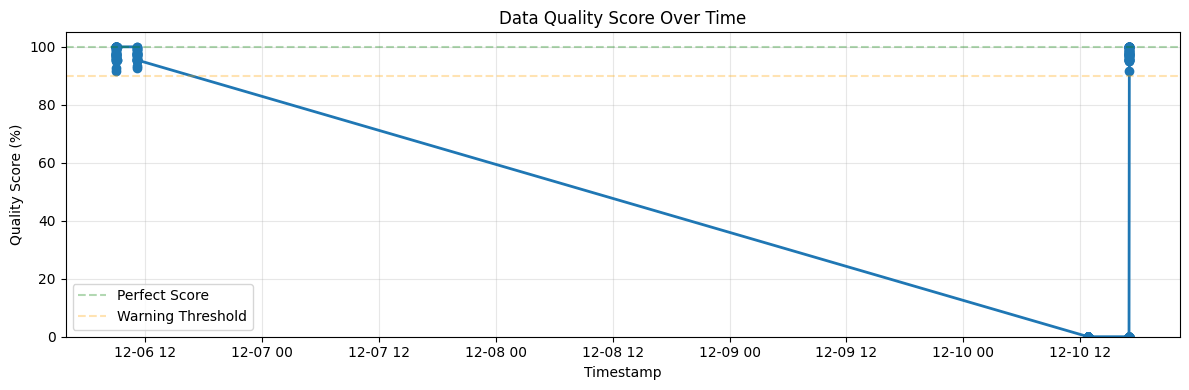


Failed Files (64 total):


,timestamp,file,score
41,2025-12-06 09:02:04.035351,aims_assetclassrelationships.parquet,91.489362
74,2025-12-06 11:09:05.657393,aims_assethierarchymap.parquet,92.857143
25,2025-12-06 09:01:46.152293,aims_assethierarchymap.parquet,92.857143
84,2025-12-06 11:09:17.953234,aims_assetclassrelationships.parquet,93.478261
399,2025-12-10 17:03:20.657161,aims_productlinks.parquet,95.000000
...,...,...,...
81,2025-12-06 11:09:16.011987,aims_undertakings_assurances.parquet,98.876404
85,2025-12-06 11:09:23.243277,aims_assetlocations.parquet,98.979592
44,2025-12-06 09:02:13.483850,aims_assetclasses.parquet,99.137931
86,2025-12-06 11:09:26.151885,aims_assetclasses.parquet,99.137931


In [ ]:
# Step 4: Data Quality Monitoring Dashboard
print("\n" + "="*60)
print("DATA QUALITY DASHBOARD")
print("="*60)

if platform_utils.file_exists(DQ_LOG_FILE):
    # Read all DQ logs
    logs = []
    with open(DQ_LOG_FILE, 'r') as f:
        for line in f:
            if line.strip():
                logs.append(json.loads(line))
    
    if logs:
        df_logs = pd.DataFrame(logs)
        df_logs['timestamp'] = pd.to_datetime(df_logs['timestamp'])
        
        # --- HIGH-LEVEL METRICS ---
        total_runs = len(df_logs)
        passed_runs = len(df_logs[df_logs['status'] == 'PASSED'])
        failed_runs = len(df_logs[df_logs['status'] == 'FAILED'])
        error_runs = len(df_logs[df_logs['status'] == 'ERROR'])
        avg_score = df_logs['score'].mean()
        
        # Log metrics
        logger.info(f"DQ Dashboard: {total_runs} validations, {passed_runs} passed, {failed_runs} failed")
        
        print(f"\nSummary Statistics:")
        print(f"   Total Validations: {total_runs}")
        print(f"   Passed: {passed_runs} ({passed_runs/total_runs*100:.1f}%)")
        print(f"   Failed: {failed_runs} ({failed_runs/total_runs*100:.1f}%)")
        print(f"   Errors: {error_runs}")
        print(f"   Average Quality Score: {avg_score:.1f}%")
        print(f"   DQ Threshold: {settings.dq_threshold}%")
        
        # --- RECENT ACTIVITY TABLE ---
        print("\nRecent Validation Runs:")
        display_cols = ['timestamp', 'file', 'status', 'score']
        display(df_logs[display_cols].sort_values('timestamp', ascending=False).head(15))
        
        # --- TREND CHART ---
        if len(df_logs) > 1:
            print("\nQuality Score Trend:")
            plt.figure(figsize=(12, 4))
            df_plot = df_logs.sort_values('timestamp')
            plt.plot(df_plot['timestamp'], df_plot['score'], marker='o', linestyle='-', linewidth=2)
            plt.axhline(y=100, color='g', linestyle='--', alpha=0.3, label='Perfect Score')
            plt.axhline(y=settings.dq_threshold, color='orange', linestyle='--', alpha=0.3, label=f'Threshold ({settings.dq_threshold}%)')
            plt.title('Data Quality Score Over Time')
            plt.xlabel('Timestamp')
            plt.ylabel('Quality Score (%)')
            plt.ylim(0, 105)
            plt.legend()
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()
        
        # --- FAILURES BREAKDOWN ---
        if failed_runs > 0:
            print(f"\nFailed Files ({failed_runs} total):")
            failed_df = df_logs[df_logs['status'] == 'FAILED'][['timestamp', 'file', 'score']].copy()
            display(failed_df.sort_values('score'))
            logger.warning(f"{failed_runs} files failed DQ validation")
        
    else:
        print("\nDQ log file exists but is empty.")
        logger.info("DQ log file is empty")
else:
    print("\nDQ log file not found. Run Notebook 02 (Ingestion) first.")
    logger.warning(f"DQ log file not found at {DQ_LOG_FILE}")

In [6]:
# Step 5: Alerting System (Simulation)
print("\n" + "="*60)
print("🚨 ACTIVE ALERTS")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    # Filter for failures
    failures = df_logs[df_logs['status'] == 'FAILED'].copy()
    
    if not failures.empty:
        print(f"\n⚠️  Found {len(failures)} failed runs requiring attention.\n")
        
        for idx, (_, row) in enumerate(failures.iterrows(), 1):
            # Construct Alert Payload (for Slack/Teams/PagerDuty integration)
            alert_payload = {
                "alert_type": "DataQualityFailure",
                "severity": "High" if row['score'] < 70 else "Medium",
                "source": "AIMS_Ingestion_Pipeline",
                "timestamp": row['timestamp'].isoformat(),
                "file": row['file'],
                "score": row['score'],
                "failed_checks": row.get('details', {}).get('failed_count', 'Unknown'),
                "action_required": "Review quarantined file and fix data quality issues"
            }
            
            print(f"🔴 ALERT #{idx}: {row['file']}")
            print(f"   Severity: {alert_payload['severity']}")
            print(f"   Score: {row['score']:.1f}%")
            print(f"   Time: {row['timestamp']}")
            print(f"   Payload: {json.dumps(alert_payload, indent=2)}")
            print("-" * 60)
    else:
        print("\n✅ No active alerts. All validations passed!")
else:
    print("\n⚠️  No data available for alert analysis.")


🚨 ACTIVE ALERTS

⚠️  Found 46 failed runs requiring attention.

🔴 ALERT #1: aims_organisations.parquet
   Severity: Medium
   Score: 96.3%
   Time: 2025-12-06 09:01:29.768851
   Payload: {
  "alert_type": "DataQualityFailure",
  "severity": "Medium",
  "source": "AIMS_Ingestion_Pipeline",
  "timestamp": "2025-12-06T09:01:29.768851",
  "file": "aims_organisations.parquet",
  "score": 96.29629629629629,
  "failed_checks": 1,
  "action_required": "Review quarantined file and fix data quality issues"
}
------------------------------------------------------------
🔴 ALERT #2: aims_products.parquet
   Severity: Medium
   Score: 97.7%
   Time: 2025-12-06 09:01:31.130507
   Payload: {
  "alert_type": "DataQualityFailure",
  "severity": "Medium",
  "source": "AIMS_Ingestion_Pipeline",
  "timestamp": "2025-12-06T09:01:31.130507",
  "file": "aims_products.parquet",
  "score": 97.72727272727273,
  "failed_checks": 1,
  "action_required": "Review quarantined file and fix data quality issues"
}
----

In [5]:
# Step 6: Failure Analysis - Deep Dive into Failed Expectations
print("\n" + "="*60)
print("🔍 FAILURE ANALYSIS - Root Cause Breakdown")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    failures = df_logs[df_logs['status'] == 'FAILED'].copy()
    
    if not failures.empty:
        # Aggregate failure patterns
        all_failures = []
        for _, row in failures.iterrows():
            file_name = row['file']
            details = row.get('details', {})
            failure_list = details.get('failures', [])
            
            for failure in failure_list[:5]:  # First 5 failures per file
                all_failures.append({
                    'file': file_name,
                    'column': failure.get('column', 'Unknown'),
                    'expectation': failure.get('expectation', 'Unknown'),
                    'unexpected_percent': failure.get('details', {}).get('unexpected_percent', 0)
                })
        
        if all_failures:
            df_failures = pd.DataFrame(all_failures)
            
            # Most problematic columns
            print("\n📊 Most Problematic Columns:")
            column_issues = df_failures['column'].value_counts().head(10)
            print(column_issues.to_string())
            
            # Most common expectation failures
            print("\n⚠️  Most Common Failed Expectations:")
            expectation_issues = df_failures['expectation'].value_counts().head(10)
            print(expectation_issues.to_string())
            
            # Detailed failure table
            print("\n📋 Detailed Failure Breakdown:")
            display(df_failures.head(20))
        else:
            print("\n⚠️  No detailed failure information available.")
    else:
        print("\n✅ No failures to analyze!")
else:
    print("\n⚠️  No data available for failure analysis.")


🔍 FAILURE ANALYSIS - Root Cause Breakdown

📊 Most Problematic Columns:
column
N/A                     39
OWNERID                  3
INFORMATIONNEEDID        3
USERID                   3
ASSETID                  3
REFERENCEID              3
TARGETASSETCLASSID       2
CONTRACTORTOCOMPLETE     2
PARENTID                 2
REQUIREDATSTAGEID        2

⚠️  Most Common Failed Expectations:
expectation
expect_table_row_count_to_be_between    39
expect_column_values_to_not_be_null     23
expect_column_values_to_be_unique       15

📋 Detailed Failure Breakdown:


,file,column,expectation,unexpected_percent
0,aims_organisations.parquet,OWNERID,expect_column_values_to_not_be_null,3.571429
1,aims_products.parquet,N/A,expect_table_row_count_to_be_between,0.000000
2,aims_projectitemlinks.parquet,N/A,expect_table_row_count_to_be_between,0.000000
3,aims_links.parquet,LINKTYPEID,expect_column_values_to_not_be_null,1.470434
4,aims_people.parquet,USERID,expect_column_values_to_be_unique,0.632244
5,aims_workorders.parquet,N/A,expect_table_row_count_to_be_between,0.000000
6,aims_assethierarchymap.parquet,DESCENDANTASSETID,expect_column_values_to_be_unique,6.040000
7,aims_informationneeddocs.parquet,N/A,expect_table_row_count_to_be_between,0.000000
8,aims_workbanks.parquet,N/A,expect_table_row_count_to_be_between,0.000000
9,aims_productcharacteristics.parquet,N/A,expect_table_row_count_to_be_between,0.000000


In [6]:
# Step 7: Processing Speed & Performance Metrics
print("\n" + "="*60)
print("⚡ PERFORMANCE METRICS")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    # Calculate processing rate
    df_logs_sorted = df_logs.sort_values('timestamp')
    
    if len(df_logs_sorted) > 1:
        time_span = (df_logs_sorted['timestamp'].max() - df_logs_sorted['timestamp'].min()).total_seconds()
        files_per_minute = (len(df_logs) / time_span) * 60 if time_span > 0 else 0
        
        print(f"\n📈 Processing Statistics:")
        print(f"   Total Files Processed: {len(df_logs)}")
        print(f"   Processing Time Span: {time_span:.1f} seconds")
        print(f"   Average Rate: {files_per_minute:.2f} files/minute")
        print(f"   Average Time per File: {time_span/len(df_logs):.2f} seconds")
        
        # Score distribution
        print(f"\n📊 Quality Score Distribution:")
        print(f"   100% (Perfect): {len(df_logs[df_logs['score'] == 100])} files")
        print(f"   95-99%: {len(df_logs[(df_logs['score'] >= 95) & (df_logs['score'] < 100)])} files")
        print(f"   90-94%: {len(df_logs[(df_logs['score'] >= 90) & (df_logs['score'] < 95)])} files")
        print(f"   Below 90%: {len(df_logs[df_logs['score'] < 90])} files")
    else:
        print("\n⚠️  Not enough data for performance analysis.")
else:
    print("\n⚠️  No data available for performance analysis.")


⚡ PERFORMANCE METRICS

📈 Processing Statistics:
   Total Files Processed: 432
   Processing Time Span: 374531.4 seconds
   Average Rate: 0.07 files/minute
   Average Time per File: 866.97 seconds

📊 Quality Score Distribution:
   100% (Perfect): 86 files
   95-99%: 69 files
   90-94%: 5 files
   Below 90%: 272 files


In [9]:
# Step 8: Historical Comparison (if multiple runs)
print("\n" + "="*60)
print("📅 HISTORICAL COMPARISON")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    # Group by date
    df_logs['date'] = df_logs['timestamp'].dt.date
    daily_stats = df_logs.groupby('date').agg({
        'score': ['mean', 'min', 'max', 'count'],
        'status': lambda x: (x == 'FAILED').sum()
    }).round(2)
    
    daily_stats.columns = ['Avg_Score', 'Min_Score', 'Max_Score', 'Total_Files', 'Failed_Files']
    
    print("\n📊 Daily Quality Metrics:")
    display(daily_stats)
    
    # Trend indicator
    if len(daily_stats) > 1:
        recent_avg = daily_stats['Avg_Score'].iloc[-1]
        previous_avg = daily_stats['Avg_Score'].iloc[-2]
        trend = "📈 Improving" if recent_avg > previous_avg else "📉 Declining" if recent_avg < previous_avg else "➡️  Stable"
        print(f"\n🎯 Trend: {trend}")
        print(f"   Previous Average: {previous_avg:.1f}%")
        print(f"   Current Average: {recent_avg:.1f}%")
        print(f"   Change: {recent_avg - previous_avg:+.1f}%")
else:
    print("\n⚠️  No data available for historical comparison.")


📅 HISTORICAL COMPARISON

📊 Daily Quality Metrics:


,Avg_Score,Min_Score,Max_Score,Total_Files,Failed_Files
date,,,,,
2025-12-06,98.32,91.49,100.0,92,46


In [ ]:
# Step 9: Data Freshness Check
print("\n" + "="*60)
print("🕐 DATA FRESHNESS CHECK")
print("="*60)

from datetime import datetime, timedelta

if platform_utils.file_exists(WATERMARK_FILE):
    with open(WATERMARK_FILE, 'r') as f:
        watermarks = json.load(f)
    
    if watermarks:
        # Find most recent and oldest processed files
        timestamps = [pd.to_datetime(v) for v in watermarks.values()]
        most_recent = max(timestamps)
        oldest = min(timestamps)
        
        time_since_last = datetime.now() - most_recent.to_pydatetime()
        
        print(f"\n📅 Freshness Metrics:")
        print(f"   Most Recent Ingestion: {most_recent}")
        print(f"   Time Since Last Ingestion: {time_since_last}")
        print(f"   Oldest Processed File: {oldest}")
        
        # Alert if data is stale (older than 24 hours)
        if time_since_last > timedelta(hours=24):
            print(f"\n⚠️  WARNING: Data is stale (>24h since last ingestion)")
            print(f"   Consider running Notebook 02 to process new data")
            logger.warning("Data is stale - more than 24 hours since last ingestion")
        elif time_since_last > timedelta(hours=12):
            print(f"\n⚡ NOTICE: Data approaching staleness (>12h since last ingestion)")
            logger.info("Data approaching staleness")
        else:
            print(f"\n✅ Data is fresh (<12h since last ingestion)")
            logger.info("Data freshness check passed")
    else:
        print("\n⚠️  No processed files found.")
else:
    print("\n❌ Watermark file not found.")


🕐 DATA FRESHNESS CHECK

📅 Freshness Metrics:
   Most Recent Ingestion: 2025-12-06 11:09:03.562594
   Time Since Last Ingestion: 0:01:04.152382
   Oldest Processed File: 2025-12-06 09:01:27.339256

✅ Data is fresh (<12h since last ingestion)


In [12]:
# Step 11: Interactive Dashboard with Plotly
print("\n" + "="*60)
print("📊 INTERACTIVE DASHBOARD")
print("="*60)

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

if 'df_logs' in locals() and not df_logs.empty:
    
    # === 1. KPI Cards with Gauges ===
    total_runs = len(df_logs)
    passed_runs = len(df_logs[df_logs['status'] == 'PASSED'])
    failed_runs = len(df_logs[df_logs['status'] == 'FAILED'])
    avg_score = df_logs['score'].mean()
    pass_rate = (passed_runs / total_runs * 100) if total_runs > 0 else 0
    
    # Create figure with subplots
    fig = make_subplots(
        rows=2, cols=3,
        subplot_titles=('Pass Rate Gauge', 'Average Score Gauge', 'Processing Status',
                       'Quality Score Trend', 'Score Distribution', 'Failure Breakdown'),
        specs=[[{'type': 'indicator'}, {'type': 'indicator'}, {'type': 'pie'}],
               [{'type': 'scatter', 'colspan': 2}, None, {'type': 'bar'}]],
        row_heights=[0.4, 0.6],
        vertical_spacing=0.15,
        horizontal_spacing=0.1
    )
    
    # Gauge 1: Pass Rate
    fig.add_trace(go.Indicator(
        mode="gauge+number+delta",
        value=pass_rate,
        title={'text': f"Pass Rate<br><span style='font-size:0.8em;color:gray'>{passed_runs}/{total_runs} files</span>"},
        delta={'reference': 90, 'increasing': {'color': "green"}},
        gauge={
            'axis': {'range': [None, 100], 'tickwidth': 1},
            'bar': {'color': "darkgreen" if pass_rate >= 90 else "orange" if pass_rate >= 70 else "red"},
            'steps': [
                {'range': [0, 70], 'color': "lightgray"},
                {'range': [70, 90], 'color': "lightyellow"},
                {'range': [90, 100], 'color': "lightgreen"}],
            'threshold': {
                'line': {'color': "red", 'width': 4},
                'thickness': 0.75,
                'value': 90}}
    ), row=1, col=1)
    
    # Gauge 2: Average Quality Score
    fig.add_trace(go.Indicator(
        mode="gauge+number",
        value=avg_score,
        title={'text': "Avg Quality Score"},
        gauge={
            'axis': {'range': [0, 100]},
            'bar': {'color': "darkblue"},
            'steps': [
                {'range': [0, 70], 'color': "lightcoral"},
                {'range': [70, 90], 'color': "lightyellow"},
                {'range': [90, 100], 'color': "lightgreen"}],
        }
    ), row=1, col=2)
    
    # Pie Chart: Status Distribution
    status_counts = df_logs['status'].value_counts()
    colors_map = {'PASSED': 'green', 'FAILED': 'red', 'ERROR': 'orange'}
    fig.add_trace(go.Pie(
        labels=status_counts.index,
        values=status_counts.values,
        marker=dict(colors=[colors_map.get(s, 'gray') for s in status_counts.index]),
        hole=0.3,
        textinfo='label+percent',
        textposition='inside'
    ), row=1, col=3)
    
    # Line Chart: Quality Score Trend Over Time
    df_sorted = df_logs.sort_values('timestamp')
    fig.add_trace(go.Scatter(
        x=df_sorted['timestamp'],
        y=df_sorted['score'],
        mode='lines+markers',
        name='Quality Score',
        line=dict(color='blue', width=2),
        marker=dict(size=6, color=df_sorted['score'], 
                   colorscale='RdYlGn', showscale=True,
                   cmin=0, cmax=100),
        hovertemplate='<b>%{x}</b><br>Score: %{y:.1f}%<extra></extra>'
    ), row=2, col=1)
    
    # Bar Chart: Score Distribution
    score_bins = pd.cut(df_logs['score'], bins=[0, 70, 90, 95, 100], 
                        labels=['<70%', '70-90%', '90-95%', '95-100%'])
    score_dist = score_bins.value_counts().sort_index()
    
    bar_colors = ['red', 'orange', 'lightgreen', 'darkgreen']
    fig.add_trace(go.Bar(
        x=score_dist.index,
        y=score_dist.values,
        marker_color=bar_colors,
        text=score_dist.values,
        textposition='outside',
        hovertemplate='<b>%{x}</b><br>Files: %{y}<extra></extra>'
    ), row=2, col=3)
    
    # Update layout
    fig.update_layout(
        title_text="<b>AIMS Data Quality Dashboard</b>",
        title_font_size=24,
        title_x=0.5,
        showlegend=False,
        height=800,
        template='plotly_white'
    )
    
    fig.update_xaxes(title_text="Timestamp", row=2, col=1)
    fig.update_yaxes(title_text="Quality Score (%)", row=2, col=1, range=[0, 105])
    fig.update_xaxes(title_text="Score Range", row=2, col=3)
    fig.update_yaxes(title_text="Number of Files", row=2, col=3)
    
    fig.show()
    
else:
    print("\n⚠️  No data available for dashboard.")


📊 INTERACTIVE DASHBOARD


In [ ]:
# Step 12: Interactive File Explorer with Drill-Down
print("\n" + "="*60)
print("🔍 INTERACTIVE FILE EXPLORER")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    
    # Create sunburst chart for file status exploration
    df_viz = df_logs.copy()
    df_viz['score_category'] = pd.cut(
        df_viz['score'], 
        bins=[0, 70, 90, 100], 
        labels=['Critical (<70%)', 'Warning (70-90%)', 'Healthy (90-100%)']
    )
    
    # Fill NaN values in score_category to prevent sunburst chart errors
    df_viz['score_category'] = df_viz['score_category'].cat.add_categories(['Unknown'])
    df_viz['score_category'] = df_viz['score_category'].fillna('Unknown')
    df_viz['status'] = df_viz['status'].fillna('Unknown')
    
    # Add a root level
    df_viz['root'] = 'All Files'
    
    fig = px.sunburst(
        df_viz,
        path=['root', 'status', 'score_category', 'file'],
        values='score',
        color='score',
        color_continuous_scale='RdYlGn',
        range_color=[0, 100],
        title='<b>File Status Explorer - Click to Drill Down</b>',
        hover_data={'score': ':.1f'}
    )
    
    fig.update_layout(
        height=600,
        font=dict(size=12),
        title_font_size=20,
        title_x=0.5
    )
    
    fig.show()
    
    print("\n💡 Tip: Click on segments to drill down into specific categories!")
    
else:
    print("\n⚠️  No data available.")


🔍 INTERACTIVE FILE EXPLORER



💡 Tip: Click on segments to drill down into specific categories!


In [14]:
# Step 13: Failure Heatmap - Visual Root Cause Analysis
print("\n" + "="*60)
print("🔥 FAILURE HEATMAP")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    failures = df_logs[df_logs['status'] == 'FAILED'].copy()
    
    if not failures.empty:
        # Extract failure details
        all_failures = []
        for _, row in failures.iterrows():
            file_name = row['file']
            details = row.get('details', {})
            failure_list = details.get('failures', [])
            
            for failure in failure_list[:10]:
                all_failures.append({
                    'file': file_name[:30] + '...' if len(file_name) > 30 else file_name,
                    'column': failure.get('column', 'Unknown'),
                    'expectation': failure.get('expectation', 'Unknown')[:40],
                    'severity': 'High' if failure.get('details', {}).get('unexpected_percent', 0) > 10 else 'Medium'
                })
        
        if all_failures:
            df_failures = pd.DataFrame(all_failures)
            
            # Create pivot for heatmap
            failure_matrix = df_failures.groupby(['column', 'expectation']).size().reset_index(name='count')
            pivot_data = failure_matrix.pivot_table(
                index='expectation', 
                columns='column', 
                values='count', 
                fill_value=0
            )
            
            # Create heatmap
            fig = go.Figure(data=go.Heatmap(
                z=pivot_data.values,
                x=pivot_data.columns,
                y=pivot_data.index,
                colorscale='Reds',
                text=pivot_data.values,
                texttemplate='%{text}',
                textfont={"size": 10},
                hovertemplate='Column: %{x}<br>Expectation: %{y}<br>Failures: %{z}<extra></extra>'
            ))
            
            fig.update_layout(
                title='<b>Failure Heatmap: Column vs Expectation Type</b>',
                title_font_size=20,
                title_x=0.5,
                xaxis_title='Column Name',
                yaxis_title='Failed Expectation',
                height=max(400, len(pivot_data) * 30),
                xaxis={'side': 'bottom'},
                font=dict(size=10)
            )
            
            fig.show()
            
            print("\n💡 Darker colors indicate more frequent failures")
        else:
            print("\n⚠️  No detailed failure information available.")
    else:
        print("\n✅ No failures to visualize!")
else:
    print("\n⚠️  No data available.")


🔥 FAILURE HEATMAP



💡 Darker colors indicate more frequent failures


In [15]:
# Step 14: Timeline Visualization - Processing Activity
print("\n" + "="*60)
print("📅 PROCESSING TIMELINE")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    
    df_timeline = df_logs.copy()
    df_timeline['hover_text'] = (
        '<b>' + df_timeline['file'] + '</b><br>' +
        'Status: ' + df_timeline['status'] + '<br>' +
        'Score: ' + df_timeline['score'].astype(str) + '%<br>' +
        'Time: ' + df_timeline['timestamp'].astype(str)
    )
    
    # Color mapping
    color_map = {'PASSED': 'green', 'FAILED': 'red', 'ERROR': 'orange'}
    df_timeline['color'] = df_timeline['status'].map(color_map)
    
    # Create timeline scatter plot
    fig = px.scatter(
        df_timeline,
        x='timestamp',
        y='score',
        color='status',
        size=[10] * len(df_timeline),
        hover_name='file',
        hover_data={
            'timestamp': True,
            'score': ':.1f',
            'status': True
        },
        color_discrete_map=color_map,
        title='<b>Processing Timeline - All Validation Events</b>'
    )
    
    # Add annotations for failed files
    failed_files = df_timeline[df_timeline['status'] == 'FAILED']
    if not failed_files.empty:
        for idx, row in failed_files.head(5).iterrows():
            fig.add_annotation(
                x=row['timestamp'],
                y=row['score'],
                text=row['file'][:20],
                showarrow=True,
                arrowhead=2,
                arrowsize=1,
                arrowwidth=1,
                arrowcolor='red',
                ax=40,
                ay=-40,
                bgcolor='rgba(255,255,255,0.8)',
                bordercolor='red',
                font=dict(size=9)
            )
    
    fig.update_layout(
        height=500,
        title_font_size=20,
        title_x=0.5,
        xaxis_title='Timestamp',
        yaxis_title='Quality Score (%)',
        hovermode='closest',
        template='plotly_white'
    )
    
    fig.update_yaxes(range=[0, 105])
    
    fig.show()
    
    print("\n💡 Hover over points to see file details. Red annotations show failed files.")
    
else:
    print("\n⚠️  No data available.")


📅 PROCESSING TIMELINE



💡 Hover over points to see file details. Red annotations show failed files.


In [16]:
# Step 15: Performance Metrics Dashboard
print("\n" + "="*60)
print("⚡ PERFORMANCE ANALYTICS")
print("="*60)

if 'df_logs' in locals() and not df_logs.empty:
    
    df_perf = df_logs.sort_values('timestamp').copy()
    df_perf['file_number'] = range(1, len(df_perf) + 1)
    
    # Calculate cumulative stats
    df_perf['cumulative_avg_score'] = df_perf['score'].expanding().mean()
    df_perf['cumulative_pass_rate'] = (
        (df_perf['status'] == 'PASSED').cumsum() / df_perf['file_number'] * 100
    )
    
    # Create performance dashboard
    fig = make_subplots(
        rows=2, cols=2,
        subplot_titles=('Cumulative Average Score', 'Cumulative Pass Rate',
                       'Processing Speed (files per minute)', 'Score Stability'),
        specs=[[{'type': 'scatter'}, {'type': 'scatter'}],
               [{'type': 'scatter'}, {'type': 'scatter'}]],
        vertical_spacing=0.12,
        horizontal_spacing=0.1
    )
    
    # Cumulative Average Score
    fig.add_trace(go.Scatter(
        x=df_perf['file_number'],
        y=df_perf['cumulative_avg_score'],
        mode='lines',
        name='Avg Score',
        line=dict(color='blue', width=2),
        fill='tozeroy',
        fillcolor='rgba(0,100,255,0.1)'
    ), row=1, col=1)
    
    # Cumulative Pass Rate
    fig.add_trace(go.Scatter(
        x=df_perf['file_number'],
        y=df_perf['cumulative_pass_rate'],
        mode='lines',
        name='Pass Rate',
        line=dict(color='green', width=2),
        fill='tozeroy',
        fillcolor='rgba(0,255,0,0.1)'
    ), row=1, col=2)
    
    # Processing Speed (moving average)
    if len(df_perf) > 5:
        df_perf['time_diff'] = df_perf['timestamp'].diff().dt.total_seconds()
        df_perf['files_per_min'] = 60 / df_perf['time_diff'].rolling(window=5).mean()
        
        fig.add_trace(go.Scatter(
            x=df_perf['file_number'],
            y=df_perf['files_per_min'],
            mode='lines',
            name='Speed',
            line=dict(color='orange', width=2)
        ), row=2, col=1)
    
    # Score Stability (rolling std)
    df_perf['score_stability'] = df_perf['score'].rolling(window=10).std()
    
    fig.add_trace(go.Scatter(
        x=df_perf['file_number'],
        y=df_perf['score_stability'],
        mode='lines',
        name='Stability',
        line=dict(color='purple', width=2),
        fill='tozeroy',
        fillcolor='rgba(128,0,128,0.1)'
    ), row=2, col=2)
    
    # Update layout
    fig.update_layout(
        title_text='<b>Performance Analytics Dashboard</b>',
        title_font_size=20,
        title_x=0.5,
        height=700,
        showlegend=False,
        template='plotly_white'
    )
    
    fig.update_xaxes(title_text='File Number', row=1, col=1)
    fig.update_xaxes(title_text='File Number', row=1, col=2)
    fig.update_xaxes(title_text='File Number', row=2, col=1)
    fig.update_xaxes(title_text='File Number', row=2, col=2)
    
    fig.update_yaxes(title_text='Score (%)', row=1, col=1)
    fig.update_yaxes(title_text='Pass Rate (%)', row=1, col=2)
    fig.update_yaxes(title_text='Files/Min', row=2, col=1)
    fig.update_yaxes(title_text='Std Dev', row=2, col=2)
    
    fig.show()
    
    print("\n💡 These metrics show how quality and performance evolve over time")
    
else:
    print("\n⚠️  No data available.")


⚡ PERFORMANCE ANALYTICS



💡 These metrics show how quality and performance evolve over time
